<a href="https://colab.research.google.com/github/vamsiaddala2/CarPricePrediction/blob/main/CarPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Car price prediction


## Objective:
### The main objective of this data analysis is to predict a car price based on it's features. It`s also good to know which features play prominent role in determining the price.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import math
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/vamsiaddala2/CarPricePrediction/main/CarPrice_Assignment.csv")
print(df.info())
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

## Data set description

### The dataset contains detailed specifications of cars and their price. It has 205 rows and 26 columns. There are no null values
The features available are : 
        ['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']


All of them are self explinatory except "symboling". Its assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.



In [3]:
# We have no use of car_ID and carName columns. Hence we can drop them
data = df.copy()
df.drop(["car_ID", "CarName"], inplace= True, axis=1)

# Univariant Analysis

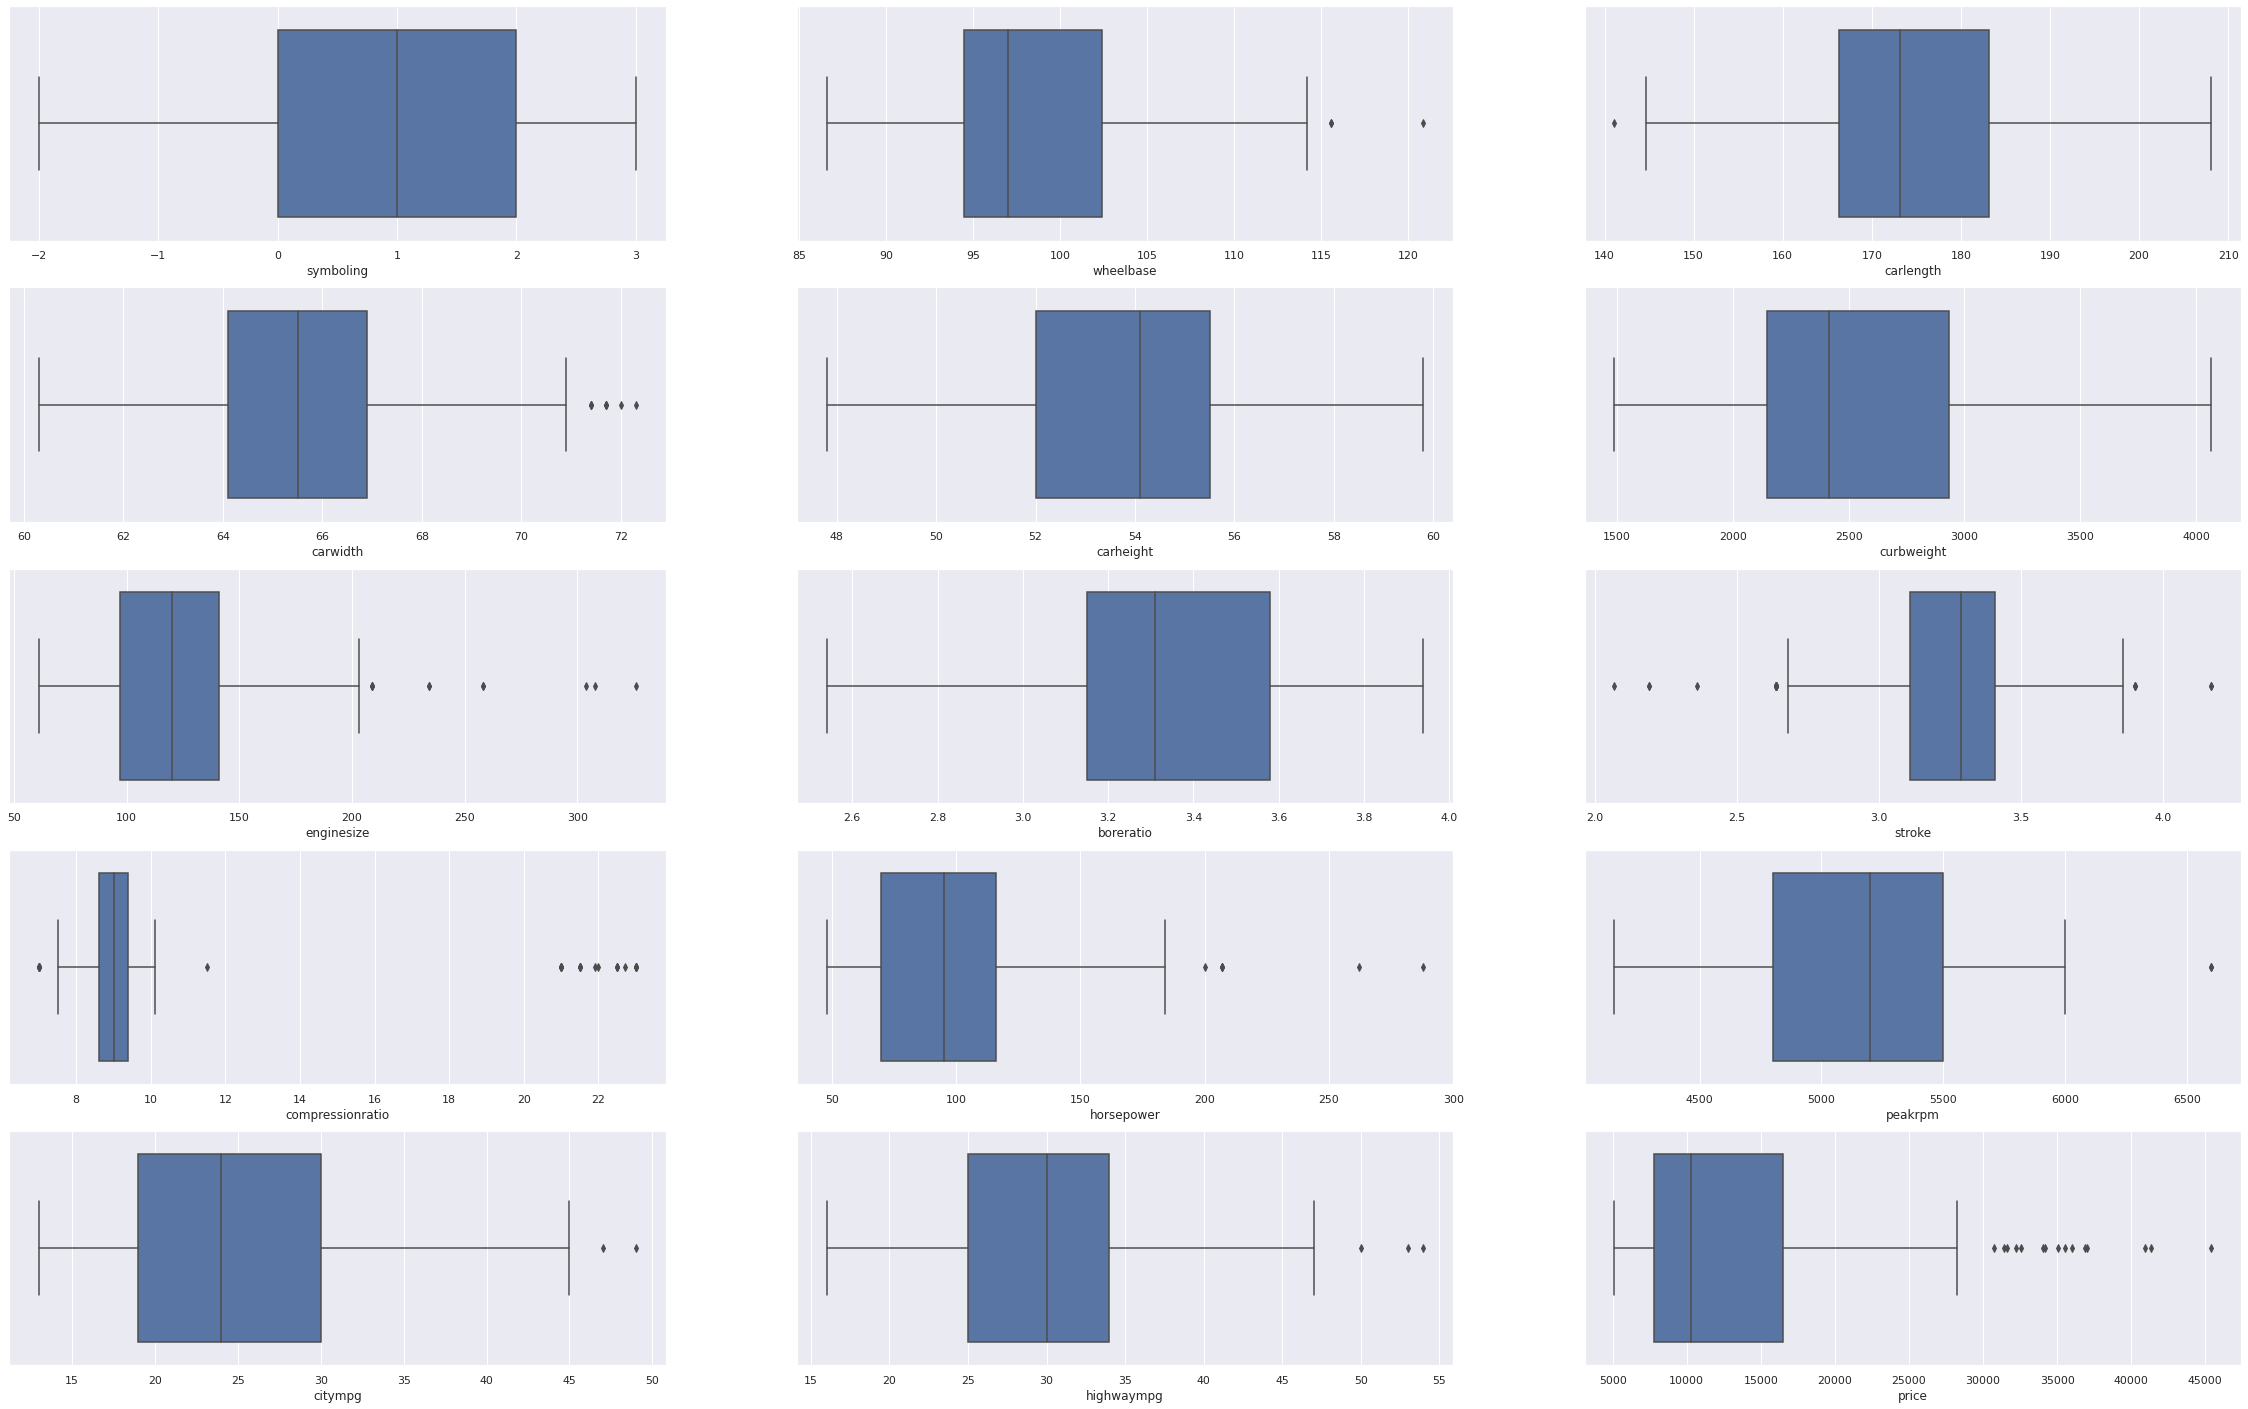

In [4]:
#let`s use boxplot to check if there are any outliers.
rowCount = math.ceil((len(df.columns[df.dtypes!=object])) / 3)
plt.figure(figsize = (40, 25))
pltno = 1
for col in df.columns[df.dtypes!=object]:
    ax = plt.subplot(rowCount, 3, pltno)
    sns.boxplot(x=df[col])
    pltno += 1
plt.show()

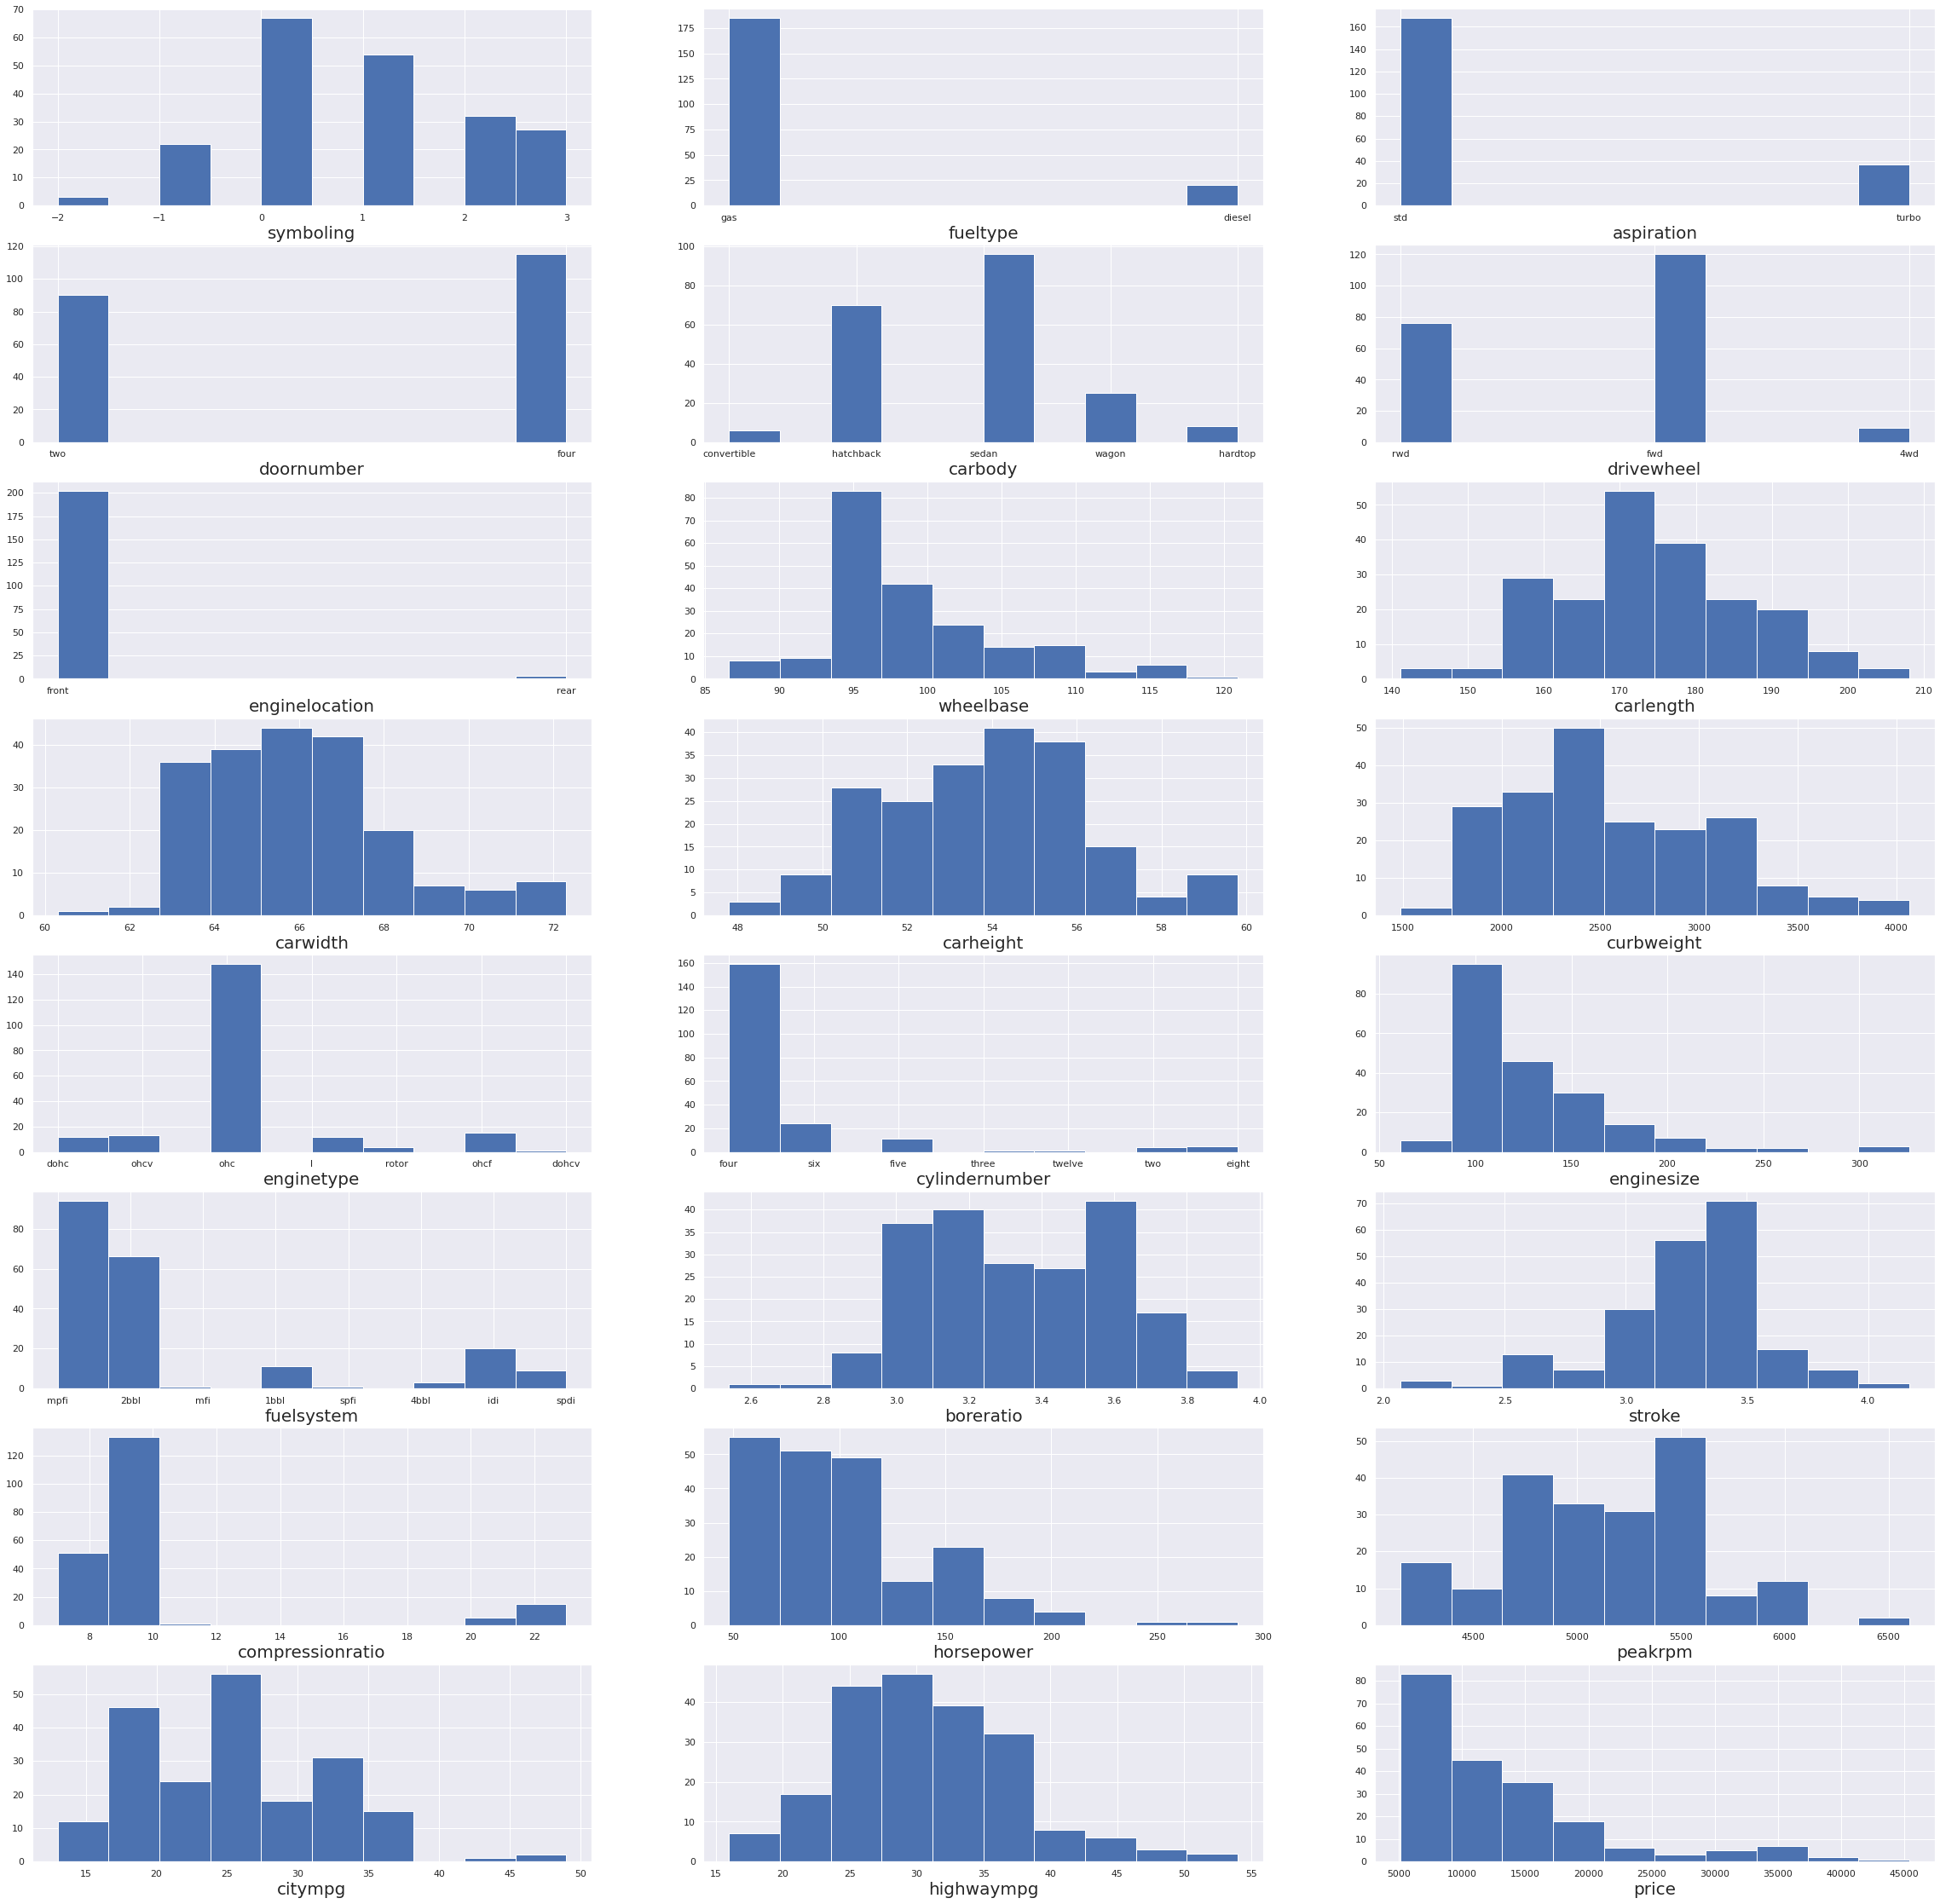

In [5]:
#Let's start our analysis with histograms
rowCount = math.ceil((len(df.columns)) / 3)
plt.figure(figsize = (40, 40))
pltno = 1
for col in df.columns:
    plt.subplot(rowCount, 3, pltno)
    df[col].hist()
    plt.xlabel(col,fontsize = 20)
    pltno += 1  
plt.show()

# Bi and Multivariante Analysis

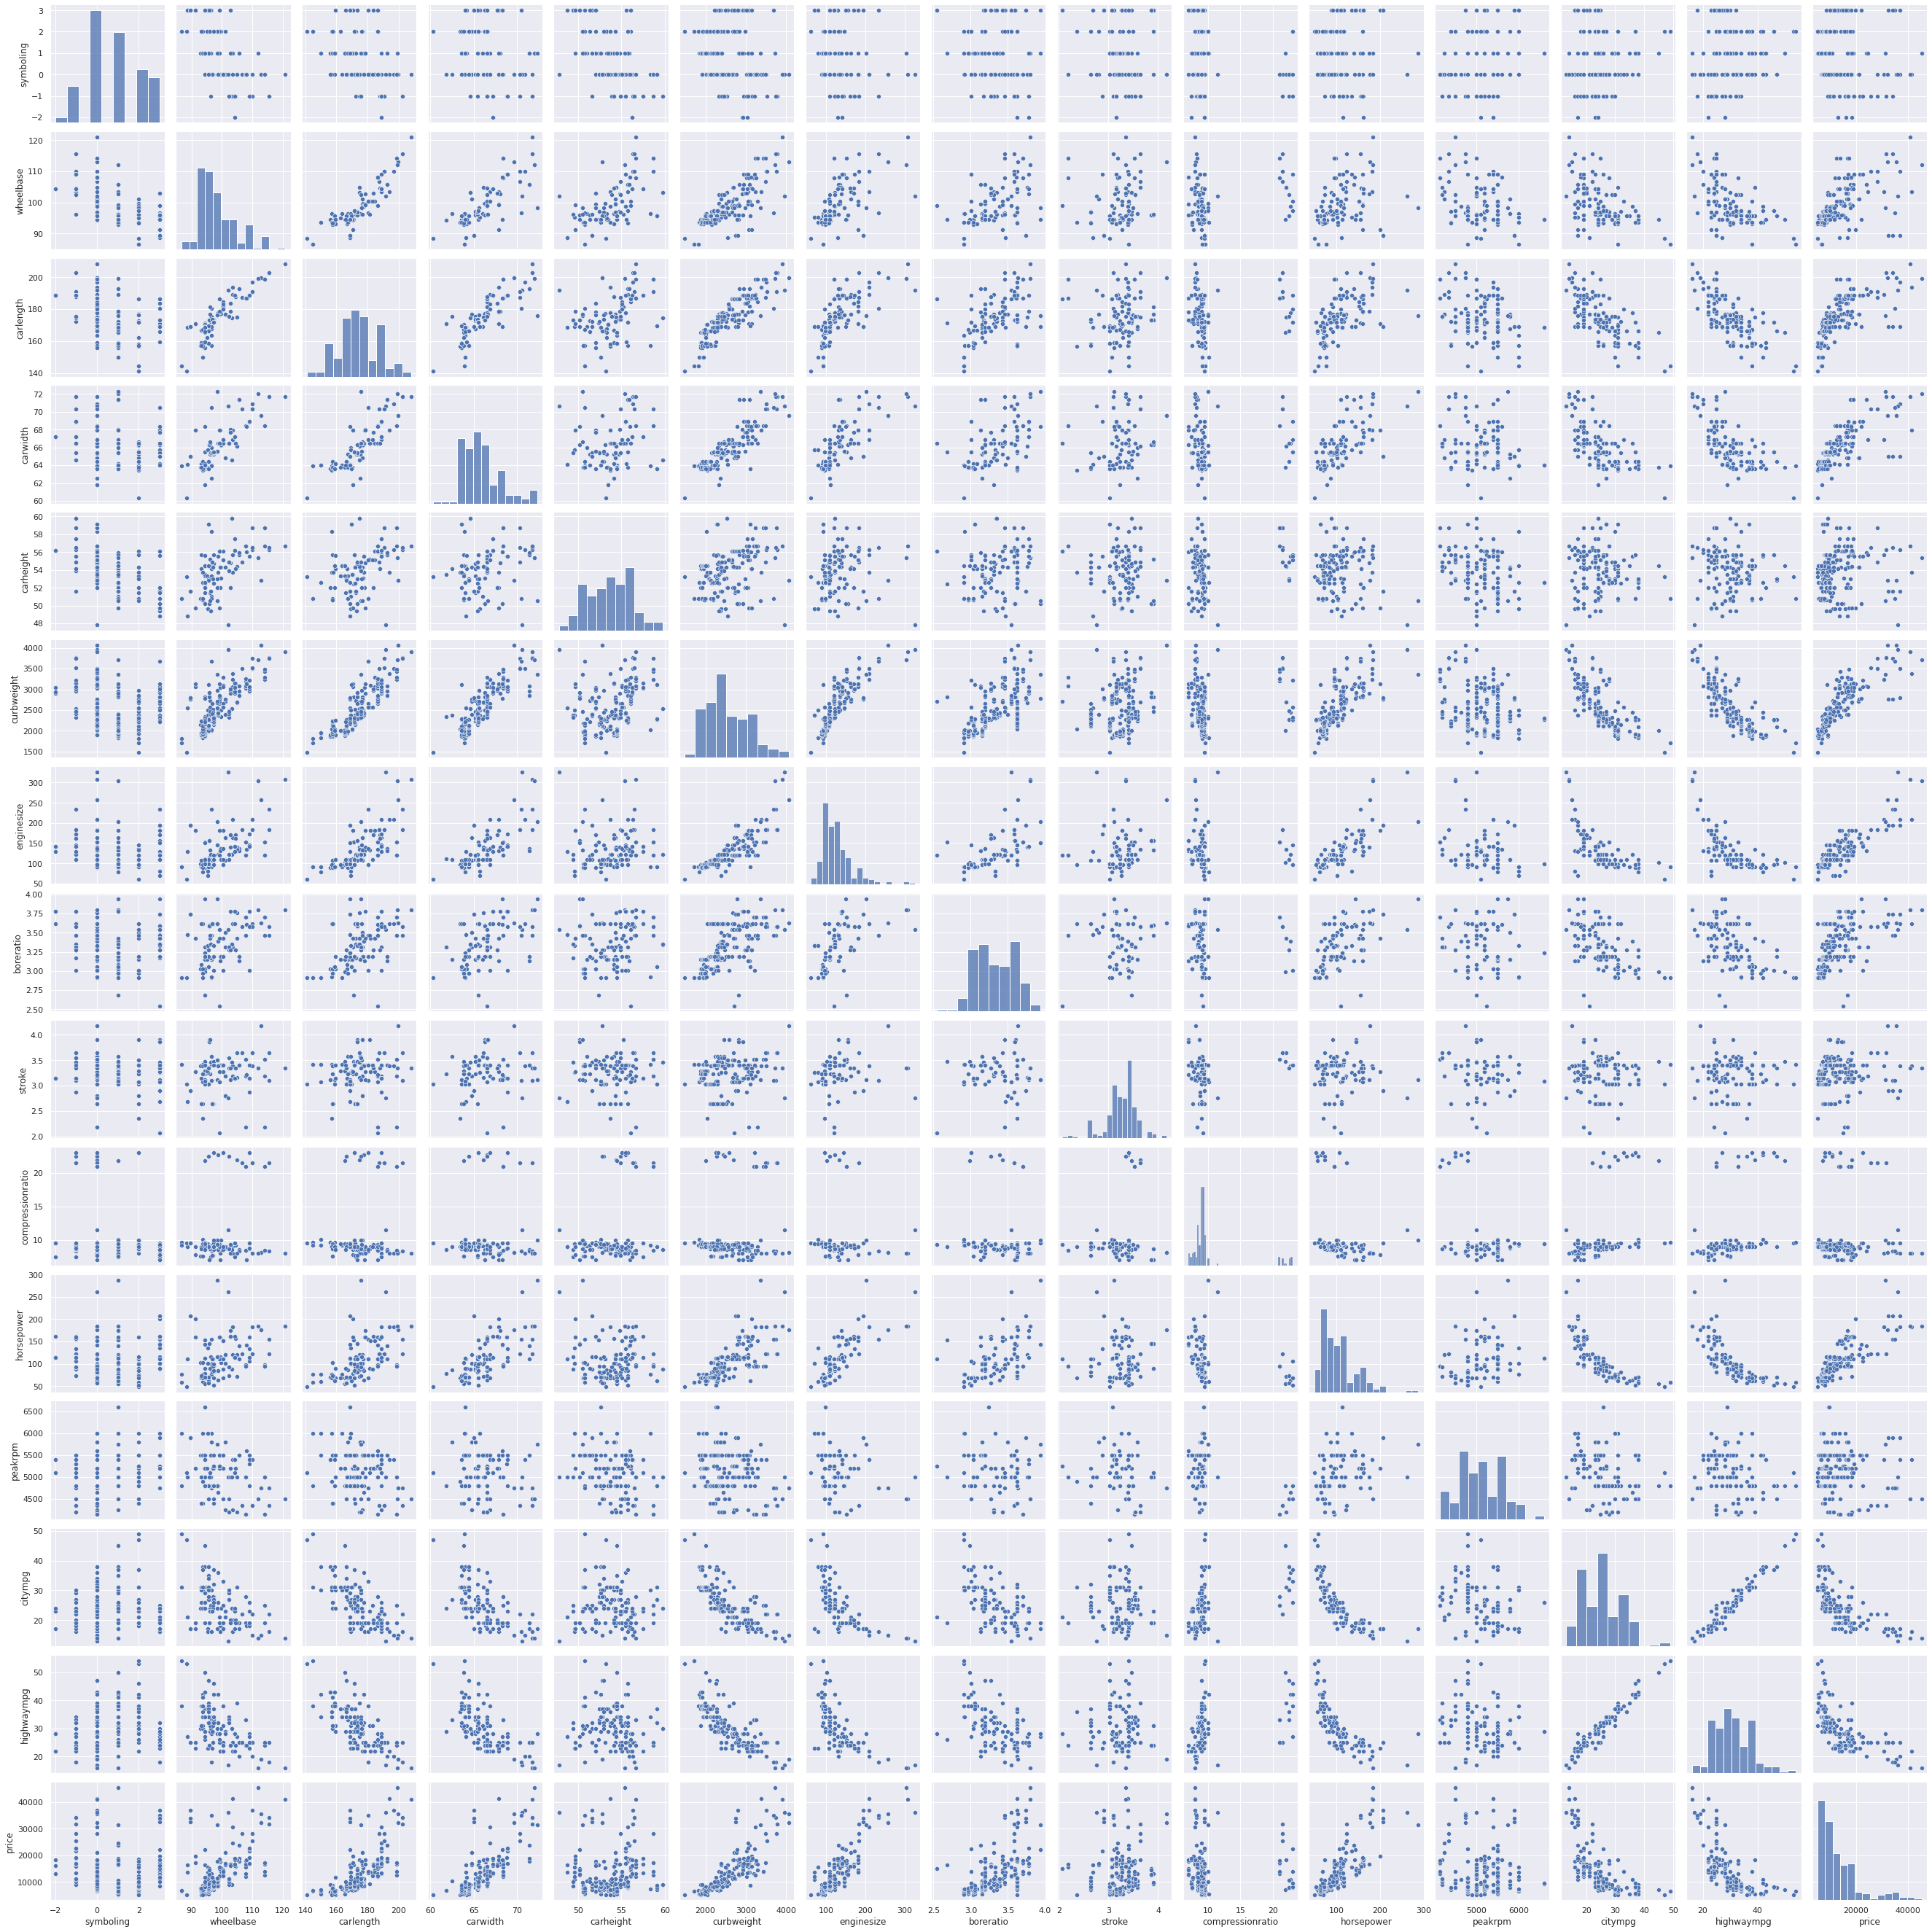

In [6]:
sns.pairplot(df)
plt.show()

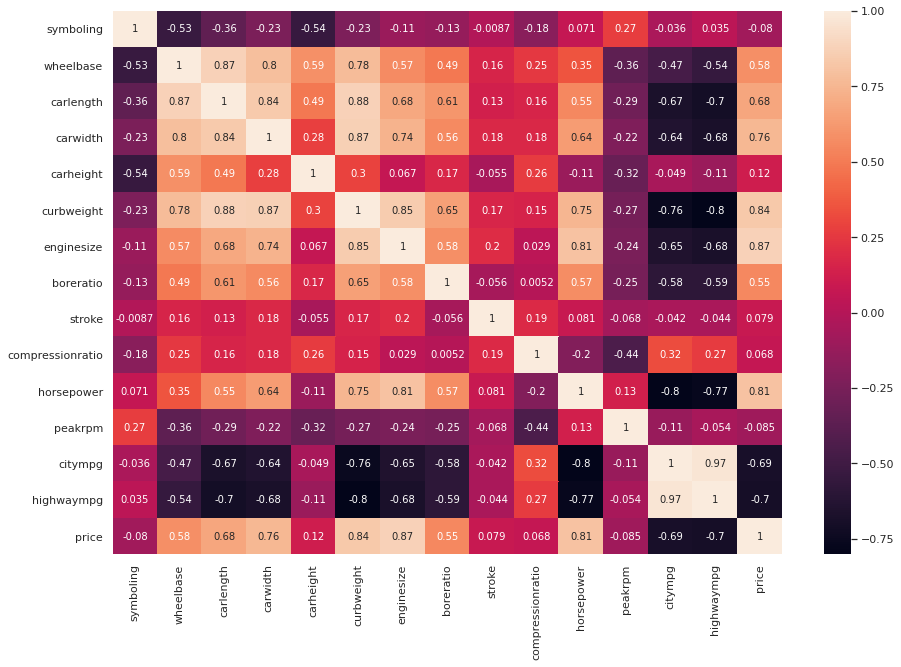

In [7]:
#let's find correlation among features
cor = df.corr()
plt.figure(figsize=(15,10))
g = sns.heatmap(cor,annot=True)
plt.show()

# Observations :
### 1. From the histograms, we could see some of the data is skewed. We will handle these later using sklearn`s PowerTransformer.
### 2. Boxplot shows some outliers. We won't drop these but later we can use sklearn`s RobustScalar, which is not sensitive to outliers.
### 3. Pairplot shows some linear relationships among features.
### 4. Correlation matrix shows significant correlation among features. This will have impact on interpretation. As our main aim is predictions, let`s skip this for now. If interpretation is important, we could drop one among two of highly correlated features

In [9]:
#splitting features and target
X = df.drop(["price"],axis=1)
y = df["price"]

In [14]:
#Splitting data into training and testing sets. 
# As the data is not huge and we are going to use Cross validation on training set, let`s just reserve 20 percent as our test set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
pf = PolynomialFeatures()
p = Pipeline(
    [("coltransformer", ColumnTransformer(
        transformers=[
            ("numeric_scaling", scaler, list(lsnonobj)),
            ("numericpolynomial", pf, list(lsnonobj)),
            ("categorical", ohe, list(lsobj)),
        ]),
    ),]
)

kf = KFold(n_splits=10, shuffle=True, random_state=1)

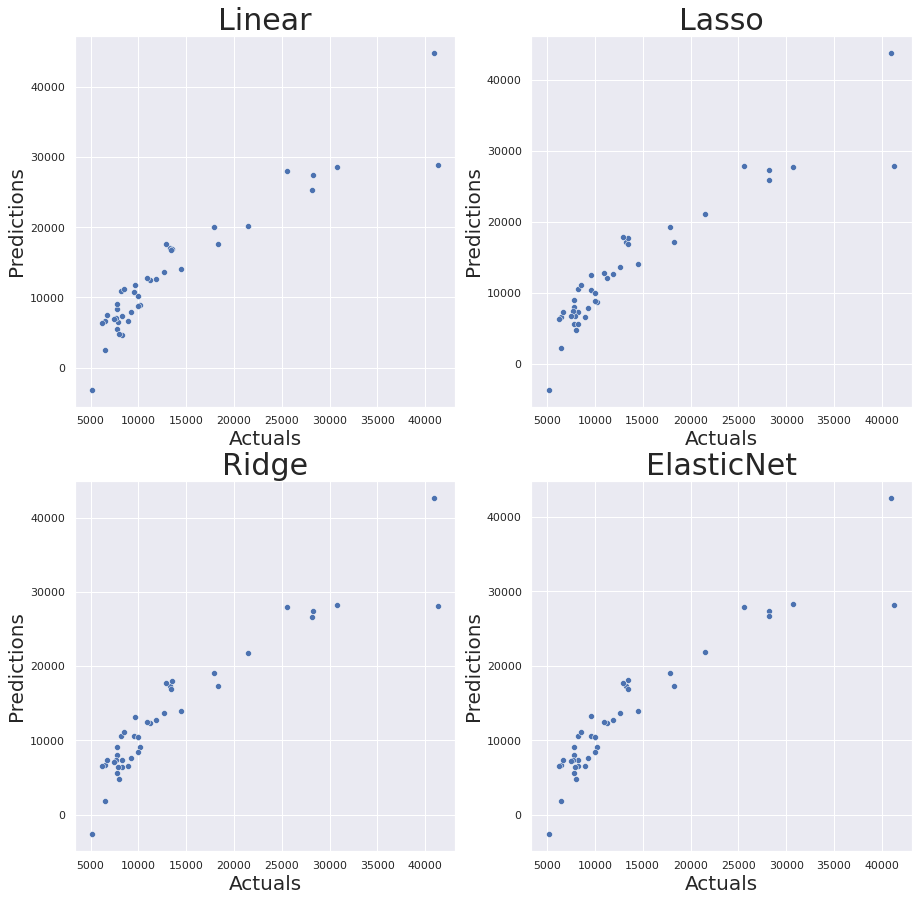

,Model,Best Score,Best Parameters,R2 score,Feature importance
0,Linear,0.855309,{'EDA__coltransformer__numericpolynomial__degr...,0.872475,"[47.53054061299999, 17.678488757144073, -6.776..."
1,Lasso,0.860151,{'EDA__coltransformer__numericpolynomial__degr...,0.864183,"[0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -450.9954..."
2,Ridge,0.869823,{'EDA__coltransformer__numericpolynomial__degr...,0.872021,"[85.06541077289518, 19.982592807042185, -6.669..."
3,ElasticNet,0.870000,{'EDA__coltransformer__numericpolynomial__degr...,0.871831,"[271.75707274586205, -696.9999204896752, -345...."


In [16]:
#Let's create a nested dictionary which contains our models and parameters and run all models sequentially using for loop
model_params = {
    "Linear": {LinearRegression() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2]}},
    "Lasso" : {Lasso() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Lasso__alpha" : np.geomspace(0.06, 6.0, 20),
                "Lasso__max_iter": [100000]}},
    "Ridge" : {Ridge() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Ridge__alpha" : np.geomspace(0.0001, 10, 20)}},
    "ElasticNet" : {ElasticNet() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "ElasticNet__alpha" : np.geomspace(0.06, 6.0, 20),
                "ElasticNet__l1_ratio": np.linspace(0.1, 0.9, 9)}},
}
models = []
best_scores = []
best_params = []
r2_scores = []
feat_imp = []
plt.figure(figsize = (15, 15))
pltno = 1

for lbl, modparams in model_params.items():
    for model, params in modparams.items():
        estimator = Pipeline([("EDA", p), (lbl, model)])
        grid = GridSearchCV(estimator, params, cv = kf)
        grid.fit(X_train, y_train)
        models.append(lbl)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        feat_imp.append(grid.best_estimator_.named_steps[lbl].coef_)
        y_predict = grid.predict(X_test)
        r2_scores.append(r2_score(y_test, y_predict))
        plt.subplot(2, 2, pltno)
        sns.scatterplot(y_test, y_predict)
        plt.xlabel("Actuals", fontsize =20)
        plt.ylabel("Predictions",fontsize =20)
        plt.title(lbl,fontsize =30)
        pltno += 1
        
plt.show()
data = list(zip(models, best_scores, best_params, r2_scores, feat_imp))
results = pd.DataFrame(data , columns=["Model", "Best Score", "Best Parameters", "R2 score", "Feature importance"])
results

#### We know the target variable is right skewed. Let's apply log transform and see if there is any improvement in any of the results.

In [17]:
X_train1,X_test1, y_train1, y_test1 = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)

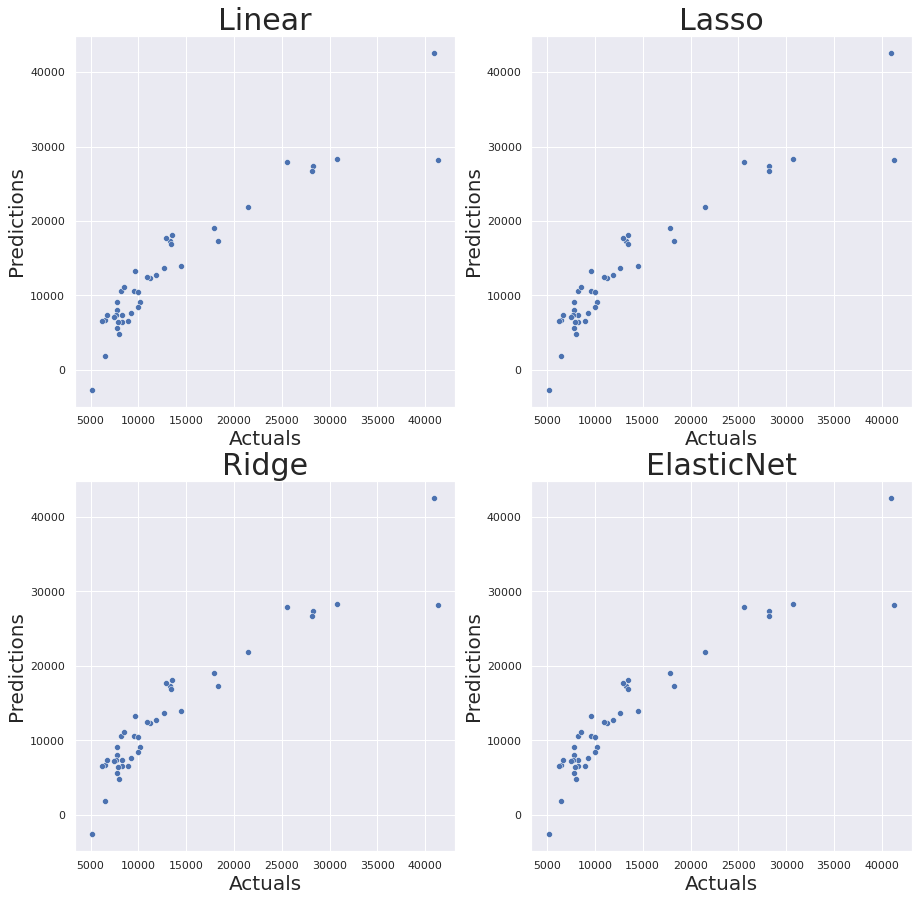

,Model,Best Score,Best Parameters,R2 score,Feature importance
0,Linear,0.866133,{'EDA__coltransformer__numericpolynomial__degr...,0.882537,"[0.0008529179480252218, 0.000752031141727498, ..."
1,Lasso,0.838337,{'EDA__coltransformer__numericpolynomial__degr...,0.870481,"[-0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0..."
2,Ridge,0.878972,{'EDA__coltransformer__numericpolynomial__degr...,0.887963,"[0.00558832054867253, 0.0007026626976432725, 6..."
3,ElasticNet,0.844376,{'EDA__coltransformer__numericpolynomial__degr...,0.869079,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03..."


In [18]:
model_params = {
    "Linear": {LinearRegression() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2]}},
    "Lasso" : {Lasso() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Lasso__alpha" : np.geomspace(0.06, 6.0, 20),
                "Lasso__max_iter": [100000]}},
    "Ridge" : {Ridge() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Ridge__alpha" : np.geomspace(0.0001, 10, 20)}},
    "ElasticNet" : {ElasticNet() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "ElasticNet__alpha" : np.geomspace(0.06, 6.0, 20),
                "ElasticNet__l1_ratio": np.linspace(0.1, 0.9, 9)}},
}
models = []
best_scores = []
best_params = []
r2_scores = []
feat_imp = []
plt.figure(figsize = (15, 15))
pltno = 1

for lbl, modparams in model_params.items():
    for model, params in modparams.items():
        estimator = Pipeline([("EDA", p), (lbl, model)])
        grid = GridSearchCV(estimator, params, cv = kf)
        grid.fit(X_train1, y_train1)
        models.append(lbl)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        feat_imp.append(grid.best_estimator_.named_steps[lbl].coef_)
        y_predict1 = grid.predict(X_test1)
        r2_scores.append(r2_score(y_test1, y_predict1))
        plt.subplot(2, 2, pltno)
        sns.scatterplot(y_test, y_predict)
        plt.xlabel("Actuals", fontsize =20)
        plt.ylabel("Predictions",fontsize =20)
        plt.title(lbl,fontsize =30)
        pltno += 1
        
plt.show()
data = list(zip(models, best_scores, best_params, r2_scores, feat_imp))
results = pd.DataFrame(data , columns=["Model", "Best Score", "Best Parameters", "R2 score", "Feature importance"])
results

#### We could see that applying log transform to our target variable resulted in minor improvement in our R2 score.
#### As we have few outliers in our data, let's use Robustscalar and check if there is any improvement.
#### Let`s run this test on log transformed target variable as it provided better r2 score.

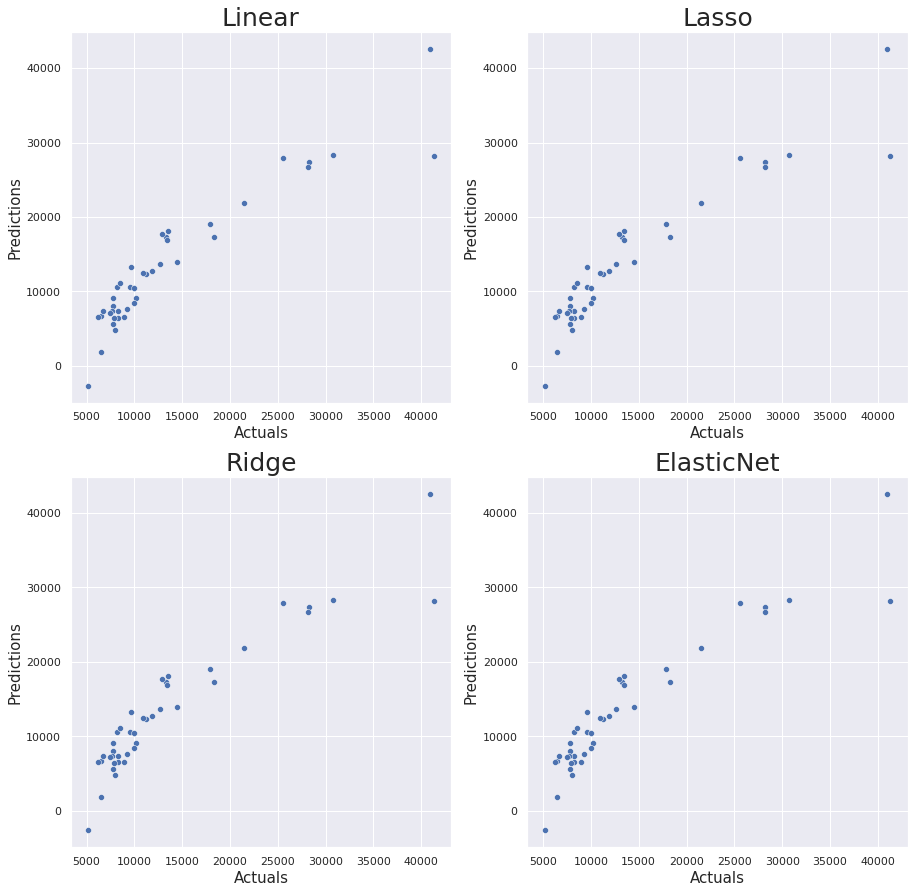

,Model,Best Score,Best Parameters,R2 score,Feature importance
0,Linear,0.866133,{'EDA__coltransformer__numericpolynomial__degr...,0.882537,"[0.0006982621395544537, 0.0005951511817639083,..."
1,Lasso,0.838337,{'EDA__coltransformer__numericpolynomial__degr...,0.870481,"[-0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0..."
2,Ridge,0.879081,{'EDA__coltransformer__numericpolynomial__degr...,0.887915,"[0.004554198486469275, 0.000555733857406109, 4..."
3,ElasticNet,0.844208,{'EDA__coltransformer__numericpolynomial__degr...,0.868274,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03..."


In [22]:
rscaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
pf = PolynomialFeatures()
p1 = Pipeline(
    [("coltransformer", ColumnTransformer(
        transformers=[
            ("numeric_scaling", rscaler, list(lsnonobj)),
            ("numericpolynomial", pf, list(lsnonobj)),
            ("categorical", ohe, list(lsobj)),
        ]),
    ),]
)

#Let's create a nested dictionary which contains our models and parameters and run all models sequentially using for loop
model_params = {
    "Linear": {LinearRegression() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2]}},
    "Lasso" : {Lasso() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Lasso__alpha" : np.geomspace(0.06, 6.0, 20),
                "Lasso__max_iter": [100000]}},
    "Ridge" : {Ridge() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Ridge__alpha" : np.geomspace(0.0001, 10, 20)}},
    "ElasticNet" : {ElasticNet() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "ElasticNet__alpha" : np.geomspace(0.06, 6.0, 20),
                "ElasticNet__l1_ratio": np.linspace(0.1, 0.9, 9)}},
}
models = []
best_scores = []
best_params = []
r2_scores = []
feat_imp = []
plt.figure(figsize = (15, 15))
pltno = 1

for lbl, modparams in model_params.items():
    for model, params in modparams.items():
        estimator = Pipeline([("EDA", p1), (lbl, model)])
        grid = GridSearchCV(estimator, params, cv = kf)
        grid.fit(X_train1, y_train1)
        models.append(lbl)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        feat_imp.append(grid.best_estimator_.named_steps[lbl].coef_)
        y_predict1 = grid.predict(X_test1)
        r2_scores.append(r2_score(y_test1, y_predict1))
        plt.subplot(2, 2, pltno)
        sns.scatterplot(y_test, y_predict)
        plt.xlabel("Actuals", fontsize =15)
        plt.ylabel("Predictions",fontsize =15)
        plt.title(lbl,fontsize =25)
        pltno += 1
        
plt.show()
data = list(zip(models, best_scores, best_params, r2_scores, feat_imp))
results = pd.DataFrame(data , columns=["Model", "Best Score", "Best Parameters", "R2 score", "Feature importance"])
results

#### Let`s see if normalising features has any impact on our R2 scores. We can use PowerTransform to normalise our features

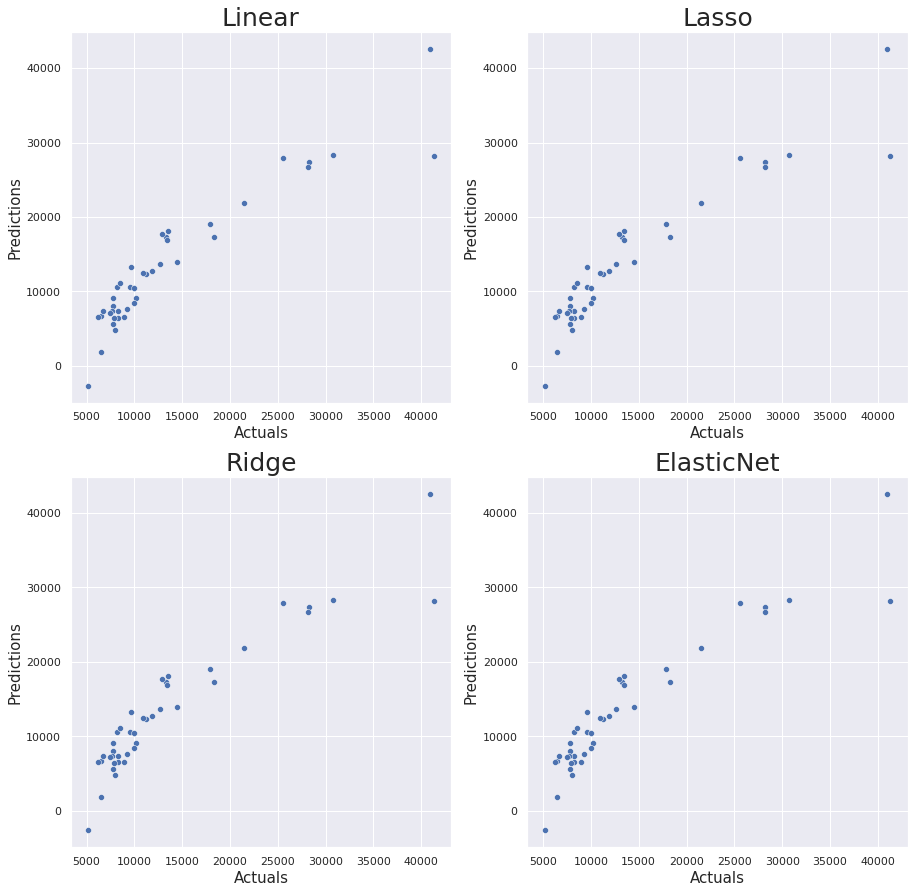

,Model,Best Score,Best Parameters,R2 score,Feature importance
0,Linear,0.819404,{'EDA__coltransformer__numericpolynomial__degr...,0.902812,"[0.08480106572637378, -0.18525374459860422, 0...."
1,Lasso,0.838337,{'EDA__coltransformer__numericpolynomial__degr...,0.870481,"[-0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, ..."
2,Ridge,0.889720,{'EDA__coltransformer__numericpolynomial__degr...,0.891679,"[0.12016602696543703, -0.07629671429004953, 0...."
3,ElasticNet,0.843758,{'EDA__coltransformer__numericpolynomial__degr...,0.867147,"[0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0..."


In [21]:
rscaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
pf = PolynomialFeatures()
pt = PowerTransformer()
p1 = Pipeline(
    [("coltransformer", ColumnTransformer(
        transformers=[
            ("numeric_PowerTransform", pt, list(lsnonobj)),
            ("numeric_scaling", rscaler, list(lsnonobj)),
            ("numericpolynomial", pf, list(lsnonobj)),
            ("categorical", ohe, list(lsobj)),
        ]),
    ),]
)

#Let's create a nested dictionary which contains our models and parameters and run all models sequentially using for loop
model_params = {
    "Linear": {LinearRegression() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2]}},
    "Lasso" : {Lasso() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Lasso__alpha" : np.geomspace(0.06, 6.0, 20),
                "Lasso__max_iter": [100000]}},
    "Ridge" : {Ridge() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "Ridge__alpha" : np.geomspace(0.0001, 10, 20)}},
    "ElasticNet" : {ElasticNet() : {"EDA__coltransformer__numericpolynomial__degree" : [1,2],
                 "ElasticNet__alpha" : np.geomspace(0.06, 6.0, 20),
                "ElasticNet__l1_ratio": np.linspace(0.1, 0.9, 9)}},
}
models = []
best_scores = []
best_params = []
r2_scores = []
feat_imp = []
plt.figure(figsize = (15, 15))
pltno = 1

for lbl, modparams in model_params.items():
    for model, params in modparams.items():
        estimator = Pipeline([("EDA", p1), (lbl, model)])
        grid = GridSearchCV(estimator, params, cv = kf)
        grid.fit(X_train1, y_train1)
        models.append(lbl)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        feat_imp.append(grid.best_estimator_.named_steps[lbl].coef_)
        y_predict1 = grid.predict(X_test1)
        r2_scores.append(r2_score(y_test1, y_predict1))
        plt.subplot(2, 2, pltno)
        sns.scatterplot(y_test, y_predict)
        plt.xlabel("Actuals", fontsize =15)
        plt.ylabel("Predictions",fontsize =15)
        plt.title(lbl,fontsize =25)
        pltno += 1
        
plt.show()
data = list(zip(models, best_scores, best_params, r2_scores, feat_imp))
results = pd.DataFrame(data , columns=["Model", "Best Score", "Best Parameters", "R2 score", "Feature importance"])
results

### We can see clearly that for vanilla linear regression, normalising features helped improving R2 score.
#### From the feature importance lists that we have created in all our steps, we could interpret our model and understand which features has high impact on price.
### Based on all the models that we have created, I would recommend using ElasticNet, as it consistently provided good accuracy and R2 score. In particular, the ElasticNet model with, PowerTransform, RobustScaling and onehotencoding features, Log transforming target variable is my choice.

## Suggestions for next steps:

#### Although the above model gives good accuracy, we can still improve it. 
#### Instead of dropping car name, we could derive car brand name from it and create a dummy variable "Brand Value" based on the  prices of that brand to total prices  (rough idea, may be some other calculation could provide better brand value). This could be really useful as we all know every brand has different price range.
#### We could also drop one of the two highly correlated variables and improve interpretability. 